In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list

#from ..utils import cross, dot, safediv, safenorm
#from desc.compute.utils import cross
#from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, 
                                  ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray


from desc.derivatives import Derivative

# Import my own functions
from desc.fns_simp import (#data_eval, 
                           #_compute_magnetic_field_from_Current,
                           plot_figure,
                           plot_figure2,
                           #plot_xy,
                           #surf_int
                          )

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory

In [3]:
#from desc.continuation import solve_continuation_automatic

from desc.objectives import (
    #AspectRatio,
    #FixBoundaryR,
    #FixBoundaryZ,
    #FixCurrent,
    #FixPressure,
    #FixPsi,
    #ForceBalance,
    ObjectiveFunction,
    #QuasisymmetryTwoTerm,
    #RotationalTransform,
    FixParameters, 
    ShareParameters,
    QuadraticFlux, 
    SurfaceCurrentRegularization, 
    bRegularization_fd,
    CoilThicknessRegularization,
    PlasmaVesselDistance,
    MeanCurvature,
    PrincipalCurvature,
)
from desc.optimize import Optimizer

In [4]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

In [5]:
eq = eq_QH

#surf_name = "/home/fcastro/DESC/docs/notebooks/R_Opt_old/opt7/surf_opt.h5"
surf_name = "/home/fcastro/DESC/docs/notebooks/R_Opt/opt8/stell2/0p5/surf_opt_2.h5"
surf = load(surf_name)

In [6]:
surf1 = surf

# Generate a Surface Current field for RQH
surf2 = surf1.copy()
#surf2.G = G_QH

surf2.change_resolution(M = 12,N = 10)
#surf2.change_Phi_resolution(M = 12,N = 12)
#surf2.M_Phi = 13
#surf2.N_Phi = 13

In [7]:
# Find B on plasma surface
egrid = LinearGrid(M = 100, N = 100)

coords = eq.compute(["R", "phi", "Z"], grid = egrid)

n_rho = eq.compute("n_rho", grid = egrid)["n_rho"]

#B = coords["B"]
coords = np.vstack([coords["R"], coords["phi"], coords["Z"]]).T

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

/home/fcastro/DESC/desc/transform.py:70: UserWarning: 

Unequal number of field periods for grid 1 and basis 3.


  warnings.warn(


<class 'numpy.ndarray'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

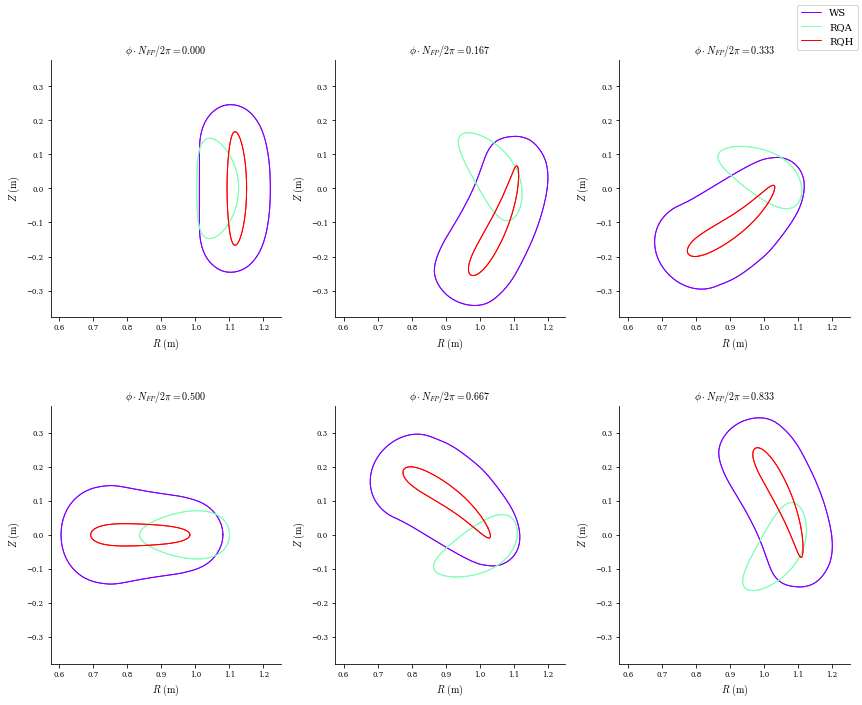

In [8]:
plot_comparison([surf2,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [9]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each

In [10]:
# Grids
Megrid = 20
Negrid = 20

Msgrid = 20
Nsgrid = 20

egrid = LinearGrid(M=Megrid,N=Negrid,
                   NFP=eq.NFP,
                   sym=False)

sgrid = LinearGrid(M=Msgrid,N=Nsgrid,
                   NFP=eq.NFP,
                   sym=False) 

In [11]:
# Distance target
min_QA = 0.07
max_QA = 0.3

min_QH = 0.07
max_QH = 0.3#0.28

# Distance to veseel penalization
obj_dist_QA = PlasmaVesselDistance(
    eq_QA,
    surf2,
    bounds=(min_QA,max_QA),
    #target = 0.15,
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    weight = 1e0,
    use_signed_distance=True,
    name="distance error  RQA"
)

obj_dist_QH = PlasmaVesselDistance(
    eq_QH,
    surf2,
    #target = 0.15,
    bounds=(min_QH,max_QH),
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    use_signed_distance=True,
    weight = 1e0,#20
    name="distance error  RQH"
)

In [12]:
mean_curv = -0.3
min_mean_curv = 0#-0.5
max_mean_curv = -0.15

obj_mean_curv = MeanCurvature(
    surf2,
    target = 0,
    #bounds = (-1,1),
    weight = 1e-2,
    normalize = True,
    normalize_target = True,
    deriv_mode = "auto",
    grid = sgrid,
    name = "Mean curvature",
)

In [13]:
obj_prin_curv = PrincipalCurvature(surf2,
        target = 0,
        #bounds=(-15,-10),
        weight=3e-2,
        #normalize=True,
        #normalize_target=True,
        #loss_function=None,
        #deriv_mode="auto",
        grid=sgrid,
        name="principal-curvature",
        #jac_chunk_size=None,
    )

In [14]:
obj = ObjectiveFunction((#flux_QA,
                         #flux_QH,
                         obj_dist_QA,
                         obj_dist_QH,
                         #obj_mean_curv,
                         obj_prin_curv,
                         #surf_curr_reg_QA,
                         #surf_curr_reg_QH,
                         #obj_thickness_QA,
                         #obj_thickness_QH,
                         #obj_sigma_QH,
                        )
                       )
constraints = (
    #FixParameters(surf1,{"G":True,}),# fix the secular poloidal current
    FixParameters(surf2,{"G":True,
                         #"R_lmn":True, 
                         #"Z_lmn":True,
                         }
                 ),# fix the secular poloidal current
    # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
    #ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), 
)

In [15]:
# Choose the optimizer
opt = Optimizer("lsq-exact")

In [16]:
# Run optimization
res,_ = opt.optimize(surf2, 
                                 objective=obj, 
                                 #constraints=constraints,
                                 verbose=3,
                                 maxiter=60,
                                ftol=0,
                                gtol=0,
                                xtol=0,
                                 #options={"initial_trust_radius":np.inf}
                      )

surf2 = res[0]

Building objective: distance error  RQA

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 859 ms

Building objective: distance error  RQH

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 36.1 ms

Building objective: principal-curvature

Precomputing transforms

<class 'numpy.ndarray'>

<class 'numpy.ndarray'>

Timer: Precomputing transforms = 39.0 ms

Timer: Objective build = 1.36 sec

Number of parameters: 747

Number of objectives: 5043

Timer: Initializing the optimization = 1.41 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          1.137e+02                                    5.257e+03   

       1              6          8.401e+01      2.965e+01      1.279e-02      7.581e+03   

       2              7          4.904e+01      3.497e+01      2.307e-02      1.868e+04   

       3              8          3.489e+01      1.415e+01      4.000e-02      2.426e+05   

       4             10          2.145e+01      1.344e+01      8.227e-03      3.293e+04   

       5             11          1.814e+01      3.318e+00      1.164e-02      8.721e+03   

       6             12          1.392e+01      4.217e+00      1.857e-02      5.570e+03   

       7             14          1.145e+01      2.466e+00      1.504e-02      8.395e+03   

       8             15          9.374e+00      2.079e+00      1.471e-02      3.997e+04   

       9             18          8.622e+00      7.513e-01      4.813e-03      6.381e+03   

      10             20          8.382e+00      2.403e-01      2.780e-03      1.681e+04   

      11             21          8.208e+00      1.740e-01      2.534e-03      1.655e+04   

      12             22          8.028e+00      1.798e-01      2.135e-03      1.489e+04   

      13             23          7.969e+00      5.907e-02      2.172e-03      1.822e+04   

      14             24          7.769e+00      2.004e-01      5.257e-04      6.662e+03   

      15             25          7.741e+00      2.784e-02      8.460e-04      1.852e+04   

      16             28          7.707e+00      3.389e-02      1.352e-05      1.076e+04   

      17             30          7.696e+00      1.112e-02      8.551e-06      7.085e+03   

      18             31          7.684e+00      1.155e-02      3.586e-05      3.441e+03   

      19             34          7.683e+00      1.056e-03      4.689e-06      2.947e+03   

      20             35          7.682e+00      1.012e-03      1.095e-05      2.852e+03   

      21             37          7.682e+00      5.174e-04      2.329e-06      2.478e+03   

      22             39          7.682e+00      2.426e-04      1.215e-06      2.375e+03   

      23             41          7.681e+00      1.053e-04      6.201e-07      1.199e+03   

      24             42          7.681e+00      1.538e-04      1.540e-06      2.347e+03   

      25             45          7.681e+00      2.934e-05      1.543e-07      2.334e+03   

      26             48          7.681e+00      3.656e-06      1.930e-08      2.332e+03   

      27             49          7.681e+00      7.305e-06      3.866e-08      2.329e+03   

      28             52          7.681e+00      9.125e-07      4.833e-09      2.329e+03   

      29             53          7.681e+00      1.825e-06      9.669e-09      2.328e+03   

      30             56          7.681e+00      2.280e-07      1.209e-09      2.328e+03   

      31             58          7.681e+00      1.140e-07      6.044e-10      2.328e+03   

      32             60          7.681e+00      5.700e-08      3.022e-10      2.328e+03   

      33             62          7.681e+00      2.850e-08      1.511e-10      2.328e+03   

      34             64          7.681e+00      1.425e-08      7.555e-11      2.328e+03   

      35             65          7.681e+00      2.850e-08      1.511e-10      2.328e+03   

      36             68          7.681e+00      3.563e-09      1.889e-11      2.328e+03   

      37             70          7.681e+00      1.781e-09      9.443e-12      2.328e+03   

      38             71          7.681e+00      3.563e-09      1.889e-11      2.328e+03   

      39             74          7.681e+00      4.453e-10      2.361e-12      2.328e+03   

      40             76          7.681e+00      2.227e-10      1.180e-12      2.328e+03   

      41             78          7.681e+00      1.113e-10      5.902e-13      2.328e+03   

      42             79          7.681e+00      2.227e-10      1.180e-12      2.328e+03   

      43             82          7.681e+00      2.783e-11      1.476e-13      2.328e+03   

      44             84          7.681e+00      1.392e-11      7.378e-14      2.328e+03   

      45             85          7.681e+00      2.783e-11      1.476e-13      2.328e+03   

      46             89          7.681e+00      8.731e-13      4.611e-15      2.328e+03   

      47             91          7.681e+00      4.308e-13      2.306e-15      2.328e+03   

      48             93          7.681e+00      2.203e-13      1.153e-15      2.328e+03   

      49             95          7.681e+00      1.075e-13      5.764e-16      2.328e+03   

      50             98          7.681e+00      0.000e+00      0.000e+00      2.328e+03   

         Current function value: 7.681e+00

         Total delta_x: 1.064e-01

         Iterations: 50

         Function evaluations: 98

         Jacobian evaluations: 50

Timer: Solution time = 18.7 sec

Timer: Avg time per step = 368 ms

                                                                 Start  -->   End

Total (sum of squares):                                      1.137e+02  -->   7.681e+00, 

Maximum Plasma-vessel distance:                              3.470e-01  -->   3.125e-01 (m)

Minimum Plasma-vessel distance:                             -5.721e-02  -->  -1.729e-02 (m)

Average Plasma-vessel distance:                              1.135e-01  -->   1.361e-01 (m)

Maximum Plasma-vessel distance:                              3.377e+00  -->   3.041e+00 (normalized)

Minimum Plasma-vessel distance:                             -5.567e-01  -->  -1.683e-01 (normalized)

Average Plasma-vessel distance:                              1.104e+00  -->   1.324e+00 (normalized)

Maximum Plasma-vessel distance:                              9.880e-02  -->   2.174e-01 (m)

Minimum Plasma-vessel distance:                              6.430e-02  -->   4.815e-02 (m)

Average Plasma-vessel distance:                              8.608e-02  -->   1.276e-01 (m)

Maximum Plasma-vessel distance:                              1.032e+00  -->   2.271e+00 (normalized)

Minimum Plasma-vessel distance:                              6.716e-01  -->   5.029e-01 (normalized)

Average Plasma-vessel distance:                              8.991e-01  -->   1.333e+00 (normalized)

Maximum absolute Principal curvature:                        6.006e+01  -->   2.751e+01 (m^-1)

Minimum absolute Principal curvature:                        5.372e-01  -->   3.188e-01 (m^-1)

Average absolute Principal curvature:                        6.764e+00  -->   6.330e+00 (m^-1)

Maximum absolute Principal curvature:                        1.128e+01  -->   5.169e+00 (normalized)

Minimum absolute Principal curvature:                        1.009e-01  -->   5.989e-02 (normalized)

Average absolute Principal curvature:                        1.271e+00  -->   1.189e+00 (normalized)

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

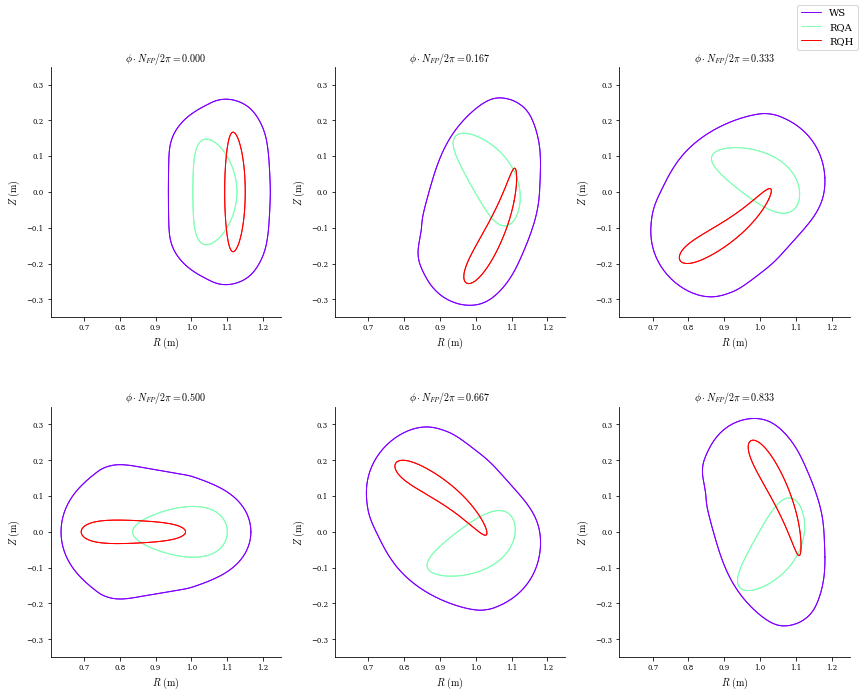

In [17]:
plot_comparison([surf2,
                 eq_QA,
                 eq_QH
                ],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

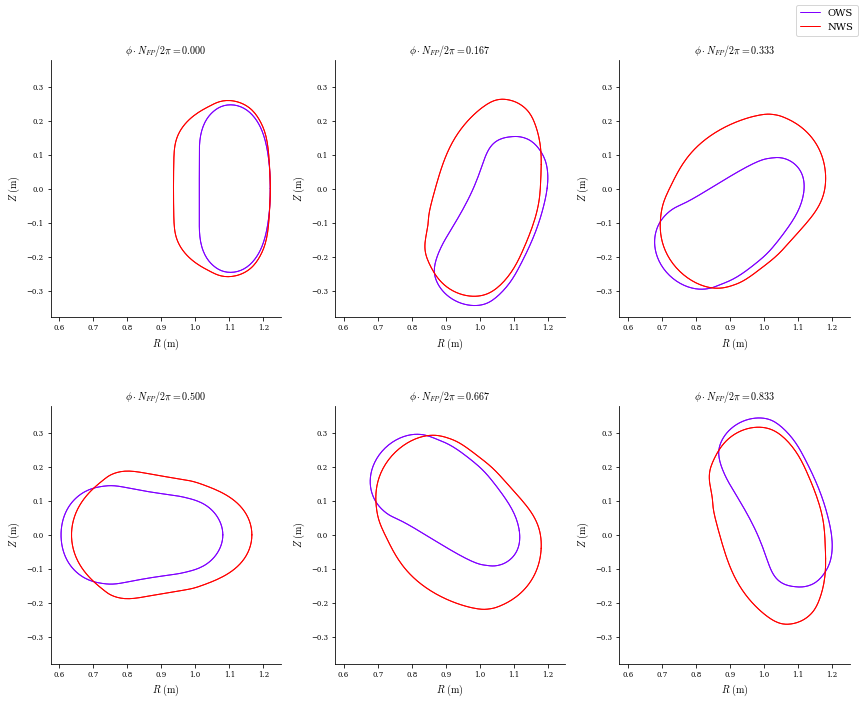

In [18]:
plot_comparison([surf,surf2],
                labels=["OWS","NWS"],
                theta=0,rho=np.array(1.0)
               )

In [19]:
#surf2.save("surf_opt_2.h5")